In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", color_codes=True)
%matplotlib inline

## Import the labelled dataset ##

In [2]:
df = pd.read_csv('data/from-azure/nathan_AllData-labelled.csv')
# df = df[df.ObstacleDensity > 0.1]

In [3]:
features_cols = ['GridSize', 'NumOfObstacles',
            'AvgDistanceToGoal', 'MaxDistanceToGoal', 'MinDistanceToGoal', 'AvgStartDistances', 'AvgGoalDistances',
            'NumOfAgents', 'ObstacleDensity', 'PointsAtSPRatio', 'Sparsity']
#                  'bridges']
# features_cols = [ 'NumOfAgents', 'ObstacleDensity', 'PointsAtSPRatio', 'NumOfObstacles']


## Replace every row with runtime greater then 300000 (5 minutes) to be 300000 - removing computation errors (somehow it kept running more than 5 minutes) ##

In [4]:
# runtime_cols = list(df.filter(like="Runtime"))

max_runtime = 300000

runtime_cols = ['EPEA*+ID Runtime',
                'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
                'ICTS 3E +ID Runtime',
                'A*+OD+ID Runtime',
                'Basic-CBS/(A*/SIC)+ID Runtime',
                'Y Runtime']
for runtime_col in runtime_cols:
    df[runtime_col] = df[runtime_col].where(df[runtime_col] < max_runtime, max_runtime)


In [5]:
# runtime_cols = list(df.filter(like="Runtime"))

runtime_cols

['EPEA*+ID Runtime',
 'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'ICTS 3E +ID Runtime',
 'A*+OD+ID Runtime',
 'Basic-CBS/(A*/SIC)+ID Runtime',
 'Y Runtime']

In [6]:
solved_df = df[df['Y Runtime'] < max_runtime] # IGNORING ALL UNSOLVED PROBLEMS

In [7]:
count_df = df['Y'].value_counts().reset_index()
count_df['BestPercentage'] = count_df.apply(lambda row: row['Y']/len(df), axis=1)
count_df

,index,Y,BestPercentage
0,MA-CBS-Global-10/(EPEA*/SIC) choosing the firs...,1416,0.455305
1,ICTS 3E +ID Runtime,678,0.218006
2,EPEA*+ID Runtime,527,0.169453
3,Basic-CBS/(A*/SIC)+ID Runtime,262,0.084244
4,A*+OD+ID Runtime,227,0.072990


In [8]:
count_df = solved_df[solved_df['Y Runtime'] < max_runtime]['Y'].value_counts().reset_index()
count_df['BestPercentage'] = count_df.apply(lambda row: row['Y']/len(solved_df), axis=1)
count_df

,index,Y,BestPercentage
0,MA-CBS-Global-10/(EPEA*/SIC) choosing the firs...,1398,0.460626
1,ICTS 3E +ID Runtime,678,0.223394
2,EPEA*+ID Runtime,527,0.173641
3,Basic-CBS/(A*/SIC)+ID Runtime,260,0.085667
4,A*+OD+ID Runtime,172,0.056672


In [9]:
print("Choosing the best alogirthm each time accuracy:", solved_df['Y'].value_counts()[0] / len(solved_df))

Choosing the best alogirthm each time accuracy: 0.46062602965403626


## Use pandas-profiling for some basic exploration. TAKES TIMES TO RUN ##

In [10]:
# import pandas_profiling

# pandas_profiling.ProfileReport(solved_df[features_cols + runtime_cols + ["Y"]])


EPEA*+ID Runtime
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime
ICTS 3E +ID Runtime
A*+OD+ID Runtime
Basic-CBS/(A*/SIC)+ID Runtime


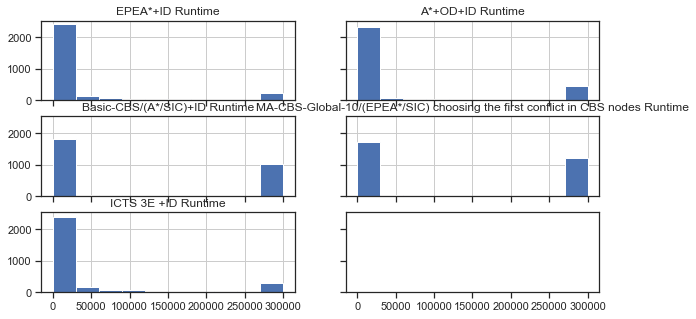

In [11]:
fig, axes = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(10,5))
index =0
for runtime_col in runtime_cols:
    if 'P Runtime' in runtime_col or 'Y Runtime' in runtime_col:
        continue
    print(runtime_col)
    solved_df[runtime_col].hist(ax=axes[index%3][index%2])
    axes[index%3][index%2].set_title(runtime_col)
    index += 1

In [12]:
# features_cols.remove('NumOfObstacles')
# features_cols.remove('MaxDistanceToGoal')
# features_cols.remove('AvgStartDistances')

## We can see that MA-CBS Fail much more then the others (reach the 300000 timeout)

In [13]:
alg_runtime_cols = runtime_cols.copy()
if 'P Runtime' in alg_runtime_cols:
    alg_runtime_cols.remove('P Runtime')
results_df = solved_df[alg_runtime_cols + features_cols].copy()
# results_df.to_csv("data/from-azure/AllData-results.csv", index=False)

## Let's see some baselines for classification models ##

## Balancing the dataset

In [14]:
# g = solved_df.groupby('Y')
# balanced_df = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

In [15]:
import xgboost as xgb

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(solved_df, solved_df['Y'], test_size=0.25)


# X_train = pd.read_csv('data/from-azure/splitted/train_features.csv')
# y_train = pd.read_csv('data/from-azure/splitted/train_labels.csv')
# X_test = pd.read_csv('data/from-azure/splitted/test_features.csv')
# y_test = pd.read_csv('data/from-azure/splitted/test_labels.csv')

In [16]:
# g = X_train.groupby('Y')
# balanced_df = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

# X_train, X_test, y_train, y_test = train_test_split(balanced_df, balanced_df['Y'], test_size=0.25)


In [17]:
def coverage_score(df, preds):
    solved = 0
    for pred, (index, row) in zip(preds,df.iterrows()):
        if(row[pred] < max_runtime):
              solved += 1
    return solved/len(df)


In [18]:
def cumsum_score(df, preds):
    cumsum = 0
    for pred, (index, row) in zip(preds,df.iterrows()):
        cumsum += row[pred]
    return cumsum/((60*(10**3)))


In [19]:
conversions = {
        0 : 'EPEA*+ID Runtime',
        1 : 'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
        2 : 'ICTS 3E +ID Runtime',
        3 : 'A*+OD+ID Runtime',
        4 : 'Basic-CBS/(A*/SIC)+ID Runtime'
    }

import numpy as np
from sklearn.metrics import accuracy_score

random_preds = [conversions[x] for x in np.random.randint(0, 5, size=(len(X_test)))]
random_baseline = accuracy_score(y_test, random_preds)
print("Choosing Random accuracy:",random_baseline)
print("Choosing Random coverage:",coverage_score(X_test, random_preds))
print("Choosing Random cumsum:",cumsum_score(X_test, random_preds))
for key, conversion in conversions.items():
    preds =  [conversion] * len(X_test)
    print("Choosing", conversion,"accuracy:",accuracy_score(y_test,preds))
    print("Choosing", conversion,"coverage:",coverage_score(X_test, preds))
    print("Choosing", conversion,"cumsum:",cumsum_score(X_test, preds))

Choosing Random accuracy: 0.19104084321475626
Choosing Random coverage: 0.8260869565217391
Choosing Random cumsum: 828.4752742099998
Choosing EPEA*+ID Runtime accuracy: 0.1541501976284585
Choosing EPEA*+ID Runtime coverage: 0.9472990777338604
Choosing EPEA*+ID Runtime cumsum: 432.15998983333384
Choosing MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime accuracy: 0.4993412384716733
Choosing MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime coverage: 0.6363636363636364
Choosing MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime cumsum: 1460.3457535916664
Choosing ICTS 3E +ID Runtime accuracy: 0.20685111989459815
Choosing ICTS 3E +ID Runtime coverage: 0.924901185770751
Choosing ICTS 3E +ID Runtime cumsum: 486.36990281833334
Choosing A*+OD+ID Runtime accuracy: 0.05665349143610013
Choosing A*+OD+ID Runtime coverage: 0.8787878787878788
Choosing A*+OD+ID Runtime cumsum: 664.4685117883331
Choosing Basic-CBS/(A*/

In [20]:
print("Choosing Optimal accuracy:",accuracy_score(y_test,X_test['Y']))

print("Choosing Optimal coverage:",coverage_score(X_test, X_test['Y']))
print("Choosing Optimal cumsum:",cumsum_score(X_test, X_test['Y']))

Choosing Optimal accuracy: 1.0
Choosing Optimal coverage: 1.0
Choosing Optimal cumsum: 170.97415117166673


In [21]:
alg_runtime_cols

['EPEA*+ID Runtime',
 'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'ICTS 3E +ID Runtime',
 'A*+OD+ID Runtime',
 'Basic-CBS/(A*/SIC)+ID Runtime',
 'Y Runtime']

In [22]:
import operator


def places_for(row, alg):
    results = {}
    sorted_results = {}
    for col in alg_runtime_cols:
        if 'Y Runtime' in col:
            continue
        results[col] = row[col]

    results = sorted(results.items(), key = operator.itemgetter(1))
    for index, (curr_alg, result) in enumerate(results):
        if curr_alg == alg:
            return index+1
    
    print("OH SHIT")

In [23]:
for alg in alg_runtime_cols:
    if 'Y Runtime' in alg:
        continue
    X_test[alg+'-results'] = X_test.apply(lambda x: places_for(x, alg), axis=1)
if 'P' in X_test:
    X_test['P Runtime-results'] = X_test.apply(lambda x: x[x['P']+'-results'], axis=1)

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
train_sorted_algorithms = X_train[alg_runtime_cols].apply(np.sort, axis=1)
test_sorted_algorithms = X_test[alg_runtime_cols].apply(np.sort, axis=1)

# df['secondplace'] = YA = A.apply(np.sort, axis = 1) 
second_y_train = train_sorted_algorithms.apply(lambda x: x[1])
second_y_test = test_sorted_algorithms.apply(lambda x: x[1])



EPEA*+ID Runtime avg place 2.7114624505928853 1.2359021769017577
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime avg place 2.4624505928853755 1.5633837202863883
ICTS 3E +ID Runtime avg place 2.9117259552042163 1.3595579945818814
A*+OD+ID Runtime avg place 3.0843214756258233 1.1535212955843879
Basic-CBS/(A*/SIC)+ID Runtime avg place 3.8300395256916997 1.3360611876393977


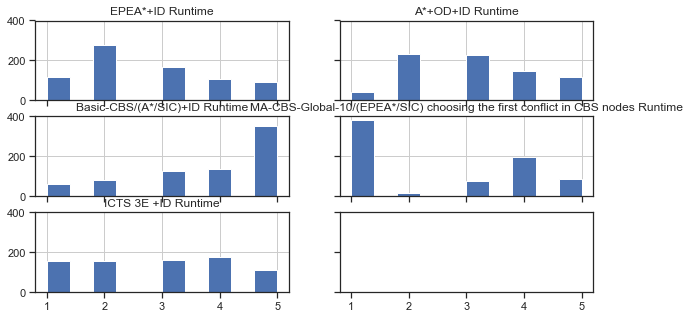

In [25]:
fig, axes = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(10,5))
index =0
    
for alg in runtime_cols:
    if 'Y Runtime' in alg:
        continue
#     X_test[(X_test.ObstacleDensity > 0.25) & (X_test.NumOfAgents > 50)][alg+'-results'].hist(ax=axes[index%3][index%2])
    X_test[alg+'-results'].hist(ax=axes[index%3][index%2])
    axes[index%3][index%2].set_title(alg)
    print(alg, "avg place", X_test[alg+'-results'].mean(), X_test[alg+'-results'].std())

    index += 1

## XGBoost training

## Regression models ##
# Important to note that the regression data is only from the classification train data! #

In [26]:
def func(x):
    return np.log1p(x)
def inverse_func(x):
    return np.expm1(x)

In [27]:
only_alg_runtime_cols = alg_runtime_cols.copy()
only_alg_runtime_cols.remove('Y Runtime')

In [28]:
train_samples_weight = X_train.apply(lambda x: np.log10(np.std(x[only_alg_runtime_cols].values)), axis=1)

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import StratifiedKFold,cross_val_score, RandomizedSearchCV, GridSearchCV
from scipy import stats

xg_regs = []
regs_data = []
index = 0
for runtime_col in runtime_cols:
    if 'P Runtime' in runtime_col or 'Y Runtime' in runtime_col:
        continue
    print(index,":",runtime_col)
    index += 1
#     reg_X_train, reg_X_test, reg_y_train, reg_y_test = train_test_split(X_train[features_cols],
#                         X_train[runtime_col], test_size=0.3)
    regs_data.append([X_train[features_cols],X_test[features_cols], X_train[runtime_col], X_test[runtime_col]])
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', min_child_weight=0.5, colsample_bytree = 0.8, learning_rate = 0.1
                              , max_depth = 3,alpha = 10, n_estimators = 75)#, colsample_bylevel= 0.5, colsample_bynode = 0.5)
    xg_reg_trans = TransformedTargetRegressor(regressor=xg_reg, func=func, inverse_func=inverse_func)
    
    param_dist = {'regressor__n_estimators': stats.randint(100, 300),
              'regressor__learning_rate': stats.uniform(0.01, 0.07),
              'regressor__subsample': stats.uniform(0.3, 0.7),
              'regressor__max_depth': [3, 4, 5, 6, 7, 8, 9],
              'regressor__colsample_bytree': stats.uniform(0.5, 0.45),
              'regressor__min_child_weight': [1, 2, 3],
              "regressor__gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
              "regressor__reg_alpha": [0, 0.5, 1],
             }

    reg = RandomizedSearchCV(xg_reg_trans, 
                             param_distributions = param_dist,
                             cv = 5,
                             n_iter = 5, 
                             scoring = 'neg_mean_squared_error',
                             error_score = 0,
                             verbose = 3,
                             n_jobs = -1)
    
    reg.fit(X_train[features_cols], X_train[runtime_col], sample_weight=train_samples_weight)
    
#     xg_reg_trans.fit(X_train[features_cols], X_train[runtime_col],sample_weight=train_samples_weight )
    
    xg_regs.append(reg.best_estimator_)


0 : EPEA*+ID Runtime
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    8.9s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.5s finished
c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1 : MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    9.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.3s finished
c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [32]:
import numpy as np

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

rmses = []
for xg_reg, reg_data in zip(xg_regs, regs_data):
    print("test label mean", np.std(reg_data[3]))
    reg_train_preds = xg_reg.predict(reg_data[0])
    reg_test_preds = xg_reg.predict(reg_data[1])
    print("Train acc:",np.sqrt(mean_squared_error(reg_data[2], reg_train_preds)))
    rmses.append(np.sqrt(mean_squared_error(reg_data[3], reg_test_preds)))
    print("Test acc:",np.sqrt(mean_squared_error(reg_data[3], reg_test_preds)))


test label mean 88639.68598156328
Train acc: 2825.137242139766
Test acc: 29424.690565159486
test label mean 144393.7193504803
Train acc: 7684.492176289786
Test acc: 34631.071480935316
test label mean 92784.66158678399
Train acc: 5765.847695319362
Test acc: 32119.928427784864
test label mean 108416.05286180074
Train acc: 16495.687820468363
Test acc: 34425.384186879804
test label mean 138439.13590738573
Train acc: 17798.2595592275
Test acc: 37859.711137044


In [33]:
np.mean(rmses)

33692.157159560695

#### Let's plot the histogram of the preidcted (log-transformed runtime) of each regressor ####

[302901.56, 300410.1, 308880.97, 303494.94, 301769.2, 310217.16, 301064.0, 303002.94, 301614.5, 302448.5, 304302.22, 310117.2, 311406.06, 303036.2, 316539.66, 331062.34] EPEA*+ID Runtime
[300151.8, 326211.16, 306350.22, 300777.94, 301376.47, 302989.78, 300685.28, 300299.84, 320626.88, 301215.0, 300053.38, 341441.12, 302200.8, 306178.06, 303057.12, 312392.06, 308345.47, 300578.1, 319079.0, 314815.06, 300657.66, 300378.03, 300073.6, 303827.84, 304027.56, 300366.06, 331659.47, 300596.12, 304051.34, 301996.62, 301879.2, 300889.2, 300081.06, 301213.75, 302694.78, 300181.53, 302629.78, 304968.06, 300790.7, 301656.3, 320126.28, 302838.84, 301573.78, 301940.62, 300194.25, 301779.2, 301876.34, 306516.44, 300181.53, 301112.2, 303298.38, 300754.75, 313900.34, 300321.56, 300078.34, 300086.7, 310969.72, 300034.88, 302331.8, 306908.28, 300760.9, 300606.22, 324602.12, 300175.84, 300228.16, 302232.53, 320886.2, 303247.5, 300400.28, 301711.8, 300593.16, 300858.4, 300420.28, 302070.06, 300045.66, 301606

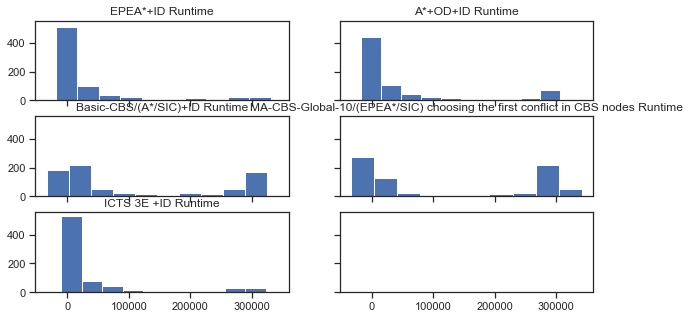

In [34]:
fig, axes = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(10,5))
index =0

for xg_reg, reg_data in zip(xg_regs, regs_data):
    reg_test_preds = xg_reg.predict(reg_data[1])
    print([p for p in reg_test_preds if p > 300000], conversions[index])
    axes[index%3][index%2].hist(reg_test_preds)
    axes[index%3][index%2].set_title(conversions[index])
    index += 1

In [35]:
xg_test_res = []
xg_train_res = []
xg_y = []
for xg_reg in xg_regs:
    xg_test_res.append(np.array(xg_reg.predict(X_test[features_cols])))
    xg_train_res.append(np.array(xg_reg.predict(X_train[features_cols])))
xg_test_res = np.array(xg_test_res)
xg_train_res = np.array(xg_train_res)

# print(xg_res.argmin(axis=0)[:4], xg_res[:,:4]) #SANITY CHECK

train_preds = [conversions[index] for index in xg_train_res.argmin(axis=0)]
test_preds = [conversions[index] for index in xg_test_res.argmin(axis=0)]
print("Regressors argmax Train acc:",accuracy_score(y_train, train_preds))
print("Regressors argmax Test acc:",accuracy_score(y_test, test_preds ))
print("Regressors argmax Test coverage:", coverage_score(X_test, test_preds))
print("Regressors argmax Test cumsum:", cumsum_score(X_test, test_preds))

Regressors argmax Train acc: 0.5184534270650264
Regressors argmax Test acc: 0.4901185770750988
Regressors argmax Test coverage: 0.9960474308300395
Regressors argmax Test cumsum: 212.96463599666663


In [36]:
features_with_reg_cols = features_cols.copy()
for key, conversion in conversions.items():
    X_test['P ' + conversion] = xg_test_res[key]
    X_train['P ' + conversion] = xg_train_res[key]
    features_with_reg_cols.append('P ' + conversion)

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Classification model ##

In [65]:
# # X_train, X_test, y_train, y_test = train_test_split(solved_df, solved_df['Y'], test_size=0.3)

# xg_cls = xgb.XGBClassifier(n_estimators=350, max_depth=3, learning_rate=0.01)

# xg_cls.fit(X_train[features_cols], y_train, sample_weight=train_samples_weight)


In [37]:
xg_cls = xgb.XGBClassifier(objective = 'multi:softmax')

param_dist = {'n_estimators': stats.randint(100, 300),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3],
              "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
              "reg_alpha": [0, 0.5, 1],
             }

clf = RandomizedSearchCV(xg_cls, 
                         param_distributions = param_dist,
                         cv = 5,
                         n_iter = 5, 
                         scoring = 'accuracy',
                         error_score = 0,
                         verbose = 3,
                         n_jobs = -1)

clf.fit(X_train[features_cols], y_train,  sample_weight=train_samples_weight)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   59.3s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min finished
c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RandomizedSearchCV(cv=5, error_score=0,
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020C3959A5F8>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020C3959A7B8>, 'subsample': [0.2, 0.4, 0.5, 0.6, 0.7], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020C3959ADD8>, 'min_child_weight': [1, 2, 3], 'gamma': [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2], 'reg_alpha': [0, 0.5, 1]},
    

In [38]:
xg_cls = clf.best_estimator_

In [39]:
train_preds = xg_cls.predict(X_train[features_cols])
test_preds = xg_cls.predict(X_test[features_cols])

In [40]:
# X_train.to_csv("data/from-azure/splitted/train_features.csv", index=False)
# y_train.to_csv("data/from-azure/splitted/train_labels.csv", index=False, header=['Y'])
# X_test.to_csv("data/from-azure/splitted/test_features.csv", index=False)
# y_test.to_csv("data/from-azure/splitted/test_labels.csv", index=False, header=['Y'])

In [42]:
print("Train acc:",accuracy_score(y_train, train_preds))
print("Test acc:",accuracy_score(y_test, test_preds))

print("Train coverage:", coverage_score(X_train, train_preds))
print("Test coverage:", coverage_score(X_test, test_preds))

print("Train cumsum:", cumsum_score(X_train, train_preds))
print("Test cumsum:", cumsum_score(X_test, test_preds))

Train acc: 0.945079086115993
Test acc: 0.8511198945981555
Train coverage: 0.9986818980667839
Test coverage: 0.9881422924901185
Train cumsum: 561.0651578683332
Test cumsum: 234.67576895833335


In [84]:
# from sklearn.model_selection import RandomizedSearchCV

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# xgb_rscv = RandomizedSearchCV(xg_cls, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 7, verbose = 3, random_state = 40)

# model_xgboost = xgb_rscv.fit(X_train[features_cols], y_train)

In [47]:
from collections import Counter
print("Predicted:", Counter(test_preds))
print("True:", Counter(X_test['Y']))

Predicted: Counter({'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime': 365, 'ICTS 3E +ID Runtime': 193, 'EPEA*+ID Runtime': 112, 'Basic-CBS/(A*/SIC)+ID Runtime': 74, 'A*+OD+ID Runtime': 15})
True: Counter({'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime': 345, 'ICTS 3E +ID Runtime': 168, 'EPEA*+ID Runtime': 135, 'Basic-CBS/(A*/SIC)+ID Runtime': 73, 'A*+OD+ID Runtime': 38})


### Binary classifiers for problem "solveness" per algorithm:

In [52]:
def runtime_to_success(col):
    splitted = col.split()
    splitted[-1] = "Success"
    return " ".join(splitted)

runtime_to_success("Y Runtime")

'Y Success'

In [110]:
for runtime_col in runtime_cols:
    if 'P Runtime' in runtime_col or 'Y Runtime' in runtime_col:
        continue
    X_train[runtime_col+"-under1m"] = X_train[runtime_col].apply(lambda x: int(x<180000))
    X_test[runtime_col+"-under1m"] = X_test[runtime_col].apply(lambda x: int(x<180000))

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [111]:
from sklearn.utils import class_weight

xg_bi_clfs = []
clfs_data = []
index = 0
for runtime_col in runtime_cols:
    if 'P Runtime' in runtime_col or 'Y Runtime' in runtime_col:
        continue
    print(index,":",runtime_col)
    index += 1
#     label = runtime_to_success(runtime_col)
    label = runtime_col+"-under1m"
    clfs_data.append([X_train[features_with_reg_cols],X_test[features_with_reg_cols], X_train[label], X_test[label]])
    class_weights = class_weight.compute_class_weight(
               'balanced',  
                [1,0], 
                X_train[label].values)  
    num_pos = len([x for x in X_train[label] if x==1])
    num_neg = len([x for x in X_train[label] if x==0])
    print(num_neg/num_pos)
    xg_bi_clf = xgb.XGBClassifier(n_estimators = 60, max_depth=4,
                                  subsample=0.9, 
                                  scale_pos_weight = (num_neg/num_pos)*3,
                                  learning_rate=0.1,
                                  colsample_bytree=1)

    xg_bi_clf.fit(X_train[features_with_reg_cols], X_train[label], sample_weight=train_samples_weight)
    
    xg_bi_clfs.append(xg_bi_clf)



0 : EPEA*+ID Runtime
0.111328125
1 : MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime
0.6834319526627219
2 : ICTS 3E +ID Runtime
0.1345962113659023
3 : A*+OD+ID Runtime
0.20359598096245374
4 : Basic-CBS/(A*/SIC)+ID Runtime
0.5143047238855623


In [112]:
from sklearn.metrics import classification_report
xg_bi_res = []

for index, (xg_bi_clf, clf_data) in enumerate(zip(xg_bi_clfs, clfs_data)):
    print(conversions[index], "Binary classifier results:")
    bi_clf_train_preds = xg_bi_clf.predict(clf_data[0])
    bi_clf_test_preds = xg_bi_clf.predict(clf_data[1])
    
#     print("Train acc:",classification_report(clf_data[2], bi_clf_train_preds))
    print("Test acc:",classification_report(clf_data[3], bi_clf_test_preds))
    print("Always one (on test) acc:", classification_report(clf_data[3], [1]*(len(clf_data[3]))))


EPEA*+ID Runtime Binary classifier results:
Test acc:               precision    recall  f1-score   support

           0       0.87      0.87      0.87        70
           1       0.99      0.99      0.99       689

   micro avg       0.98      0.98      0.98       759
   macro avg       0.93      0.93      0.93       759
weighted avg       0.98      0.98      0.98       759

Always one (on test) acc:               precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.91      1.00      0.95       689

   micro avg       0.91      0.91      0.91       759
   macro avg       0.45      0.50      0.48       759
weighted avg       0.82      0.91      0.86       759

MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime Binary classifier results:
Test acc:               precision    recall  f1-score   support

           0       0.98      0.96      0.97       317
           1       0.97      0.98      0.9

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [114]:
bi_clf_test_res = []
bi_clf_train_res = []
for bi_clf in xg_bi_clfs:
    bi_clf_test_res.append(np.array(bi_clf.predict(X_test[features_with_reg_cols])))
    bi_clf_train_res.append(np.array(bi_clf.predict(X_train[features_with_reg_cols])))
bi_clf_test_res = np.array(bi_clf_test_res)
bi_clf_train_res = np.array(bi_clf_train_res)

solved_X_train = X_train.copy()
solved_X_test = X_test.copy()
not_solved_X_test = X_test.copy()

features_with_bi_clf_cols = features_with_reg_cols.copy()
index=0
for runtime_col in runtime_cols:
    if 'P Runtime' in runtime_col or 'Y Runtime' in runtime_col:
        continue
    X_train[runtime_col+"-p-under1m"] = bi_clf_train_res[index]
    X_test[runtime_col+"-p-under1m"] = bi_clf_test_res[index]
    solved_X_train = X_train[X_train[runtime_col+"-p-under1m"]==1]
    solved_X_test = X_test[X_test[runtime_col+"-p-under1m"]==1]
    not_solved_X_test = X_test[X_test[runtime_col+"-p-under1m"]<0.5]

    print(runtime_col, len(solved_X_test), len(X_test[X_test[runtime_to_success(runtime_col)]==1]))
    print(runtime_col, len(not_solved_X_test), len(X_test[X_test[runtime_to_success(runtime_col)]==0]))

    index+=1
    if (runtime_col+"-p-under1m") not in features_with_bi_clf_cols:
        features_with_bi_clf_cols.append(runtime_col+"-p-under1m")


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


EPEA*+ID Runtime 689 710
EPEA*+ID Runtime 70 49
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime 449 451
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime 310 308
ICTS 3E +ID Runtime 690 691
ICTS 3E +ID Runtime 69 68
A*+OD+ID Runtime 643 666
A*+OD+ID Runtime 116 93
Basic-CBS/(A*/SIC)+ID Runtime 487 491
Basic-CBS/(A*/SIC)+ID Runtime 272 268


## Basic interpretation of the feature importance ##

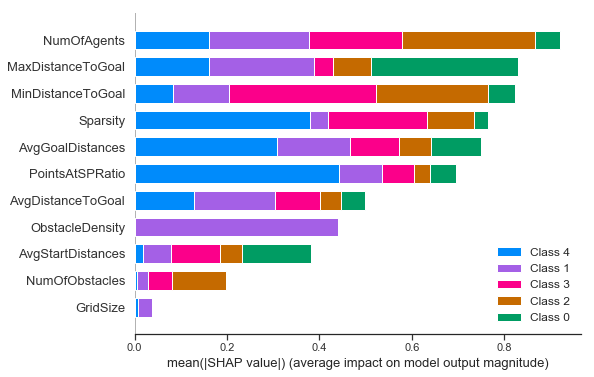

In [116]:
import shap

# load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(xg_cls)
shap_values = explainer.shap_values(X_train[features_cols])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.summary_plot(shap_values, X_train[features_cols], plot_type="bar")

## Adding 'P Success' column to indicate if the predicted algorithm finished before 5 minutes

In [53]:
X_test['P'] = xg_cls.predict(X_test[features_cols])
# solved_df['P'] = xg_cls.predict(solved_df[features_with_reg_cols])

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
X_test['P Success'] = X_test.apply(lambda x:x[runtime_to_success(x['P'])], axis=1)
# solved_df['P Success'] = solved_df.apply(lambda x:x[runtime_to_success(x['P'])], axis=1)

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
# runtime_cols.remove('P Runtime')

In [56]:
X_test['P Runtime'] = X_test.apply(lambda x:x[x['P']], axis=1)
# solved_df['P Runtime'] = solved_df.apply(lambda x:x[x['P']], axis=1)

runtime_cols.append('P Runtime')

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
runtime_per_algo = {}
for runtime in runtime_cols:
    substr_index = runtime.rfind(')')
    if(substr_index!=-1):
        key = runtime[:substr_index+1]
    else:
        key = runtime
    print(runtime)
    runtime_per_algo[key] = X_test[runtime].sum() 

EPEA*+ID Runtime
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime
ICTS 3E +ID Runtime
A*+OD+ID Runtime
Basic-CBS/(A*/SIC)+ID Runtime
Y Runtime
P Runtime


In [60]:
mean_runtime_per_algo = {}
for runtime in runtime_cols:
    substr_index = runtime.rfind(')')
    if(substr_index!=-1):
        key = runtime[:substr_index+1]
    else:
        key = runtime
    mean_runtime_per_algo[key] = X_test[runtime].std(),  X_test[runtime].mean()  

mean_runtime_per_algo

{'EPEA*+ID Runtime': (87093.26931954414, 41097.522134255596),
 'MA-CBS-Global-10/(EPEA*/SIC)': (146083.1504437459, 130366.13323333333),
 'ICTS 3E +ID Runtime': (93342.7848276071, 44352.721013833994),
 'A*+OD+ID Runtime': (110355.1347864281, 59430.391834519105),
 'Basic-CBS/(A*/SIC)': (137798.68543061207, 107914.47141317523),
 'Y Runtime': (35585.73452761548, 13049.179905928853),
 'P Runtime': (44902.99999517306, 16354.21834361001)}

In [61]:
runtime_per_algo

{'EPEA*+ID Runtime': 31193019.2999,
 'MA-CBS-Global-10/(EPEA*/SIC)': 98947895.1241,
 'ICTS 3E +ID Runtime': 33663715.2495,
 'A*+OD+ID Runtime': 45107667.4024,
 'Basic-CBS/(A*/SIC)': 81907083.8026,
 'Y Runtime': 9904327.5486,
 'P Runtime': 12412851.722799998}

<BarContainer object of 7 artists>

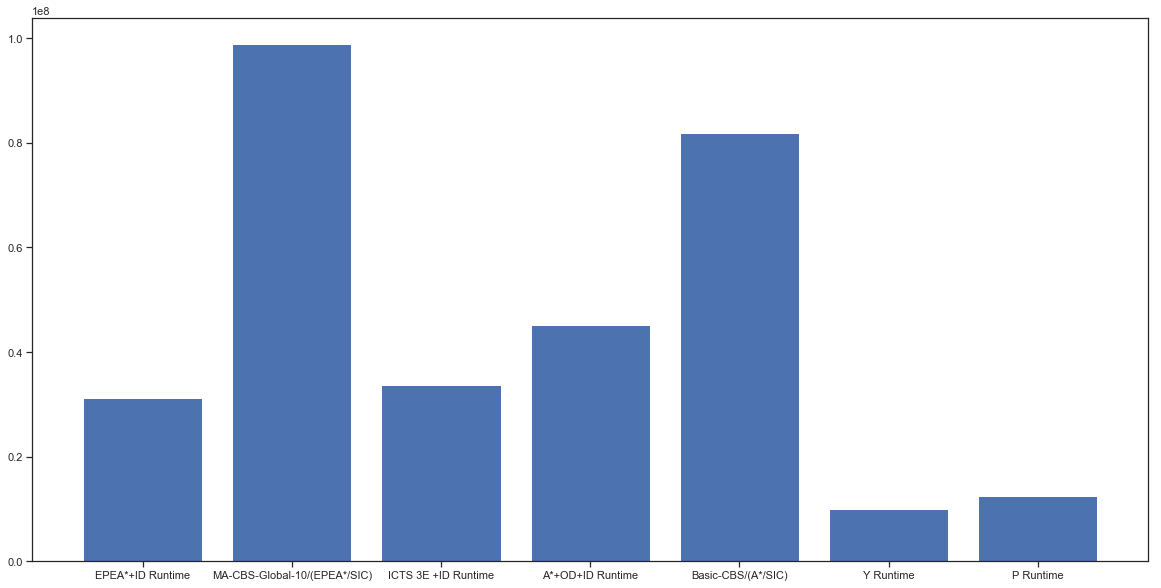

In [62]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(*zip(*runtime_per_algo.items()))

## Let's visualize the success rate of our predicted alogrithm according to the oracle  ##

EPEA*+ID Success
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Success
ICTS 3E +ID Success
A*+OD+ID Success
Basic-CBS/(A*/SIC)+ID Success
Y Success
P Success


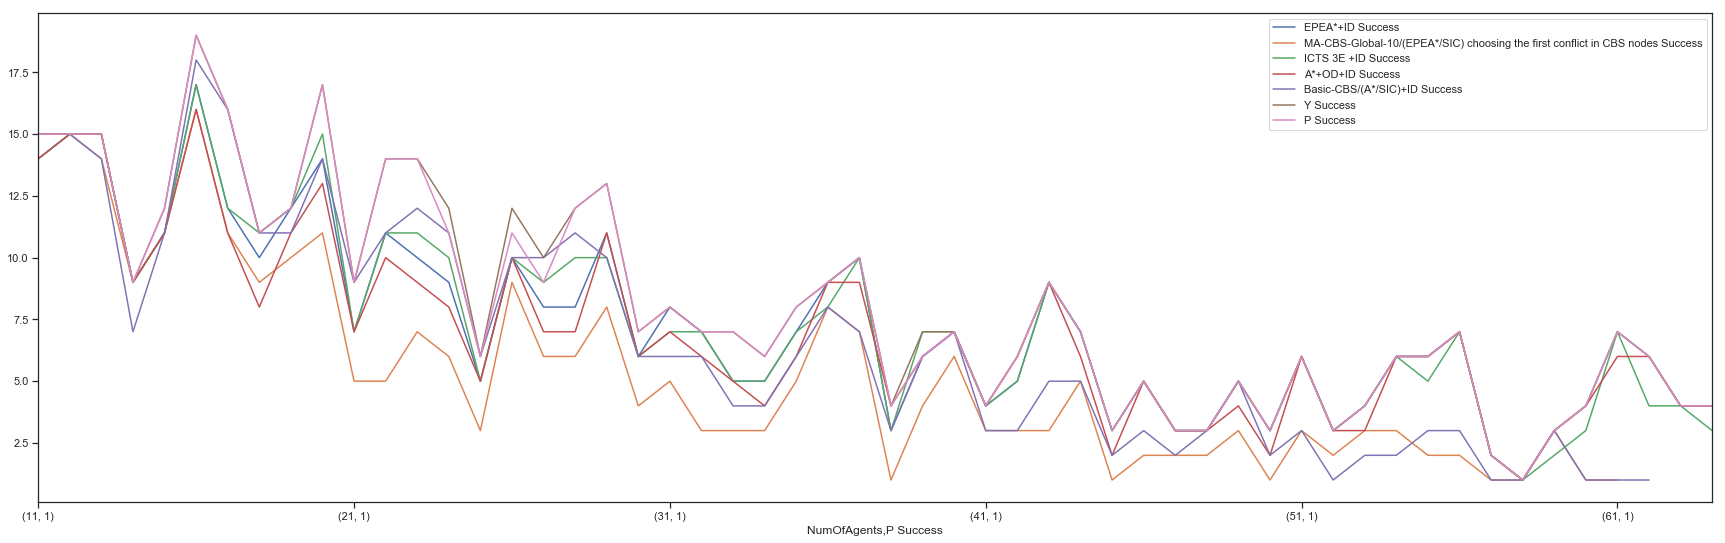

In [64]:
ax = plt.gca()
plt.rcParams["figure.figsize"] = (30,9)

for runtime_col in runtime_cols:
    print(runtime_to_success(runtime_col))
    s = X_test[X_test.NumOfAgents > 10]
    s = s[s.NumOfAgents < 65]
    s = s.groupby("NumOfAgents")[runtime_to_success(runtime_col)].value_counts()
    s.to_frame()[s.index.to_frame()[runtime_to_success(runtime_col)] == 1][runtime_to_success(runtime_col)].plot(ax=ax)
    
ax.legend()


## FROM HERE ONLY RANDOM TESTS ##

In [244]:
runtime_cols

['A*+OD+ID Runtime',
 'MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime',
 'Basic-CBS/(A*/SIC)+ID Runtime',
 'Y Runtime',
 'P Runtime']

[ 29.7495    82.502815  32.871784 100.        21.343098  23.839773
  21.230524  23.081902  24.000988  36.664284  93.174286]
['MaxDistanceToGoal' 'ObstacleDensity' 'MinDistanceToGoal'
 'AvgDistanceToGoal' 'AvgStartDistances' 'GridRows' 'NumOfAgents'
 'AvgGoalDistances' 'GridColumns' 'PointsAtSPRatio' 'NumOfObstacles']
[ 6  4  7  5  8  0  2  9  1 10  3]


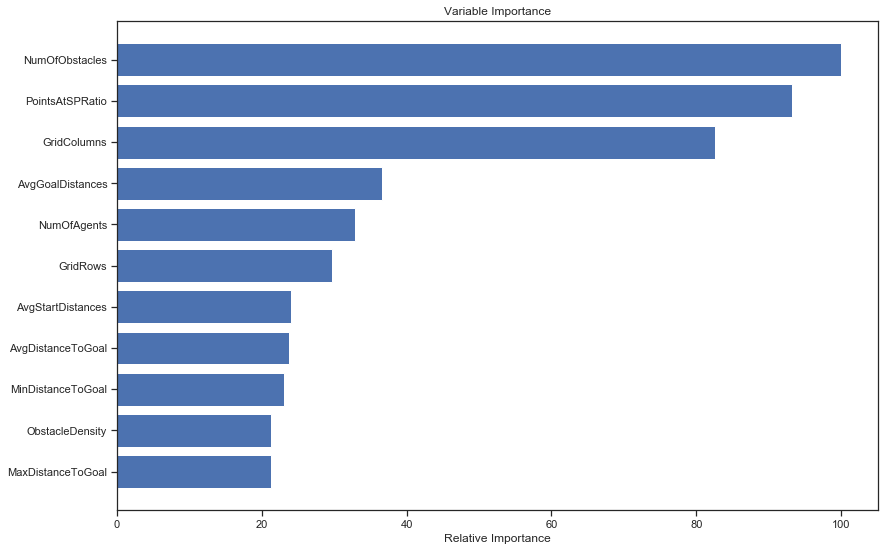

In [33]:
import numpy as np

features_cols = ['GridRows', 'GridColumns', 'NumOfAgents', 'NumOfObstacles', 'ObstacleDensity',
            'AvgDistanceToGoal', 'MaxDistanceToGoal', 'MinDistanceToGoal', 'AvgStartDistances', 'AvgGoalDistances',
            'PointsAtSPRatio']

feature_importance = xg_cls.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
print(feature_importance)
sorted_idx = np.argsort(feature_importance)
print(np.array(features_cols)[sorted_idx])
print(sorted_idx)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features_cols)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Text(0, 0.5, '')

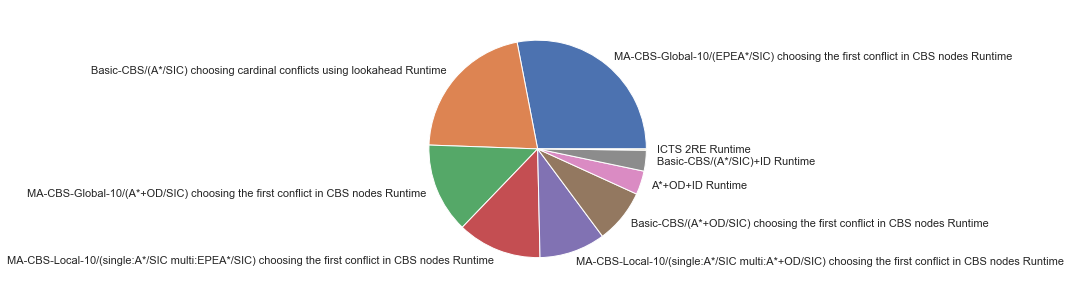

In [287]:
ax = plt.gca()
plt.rcParams["figure.figsize"] = (8,5)

pie_plt = df['Y'].value_counts().plot(kind='pie', legend=False, ax=ax)
pie_plt.set_ylabel('') #Removing column label from the plot

In [56]:
den_df['Y'].value_counts()

A*+OD+ID Runtime                                                                                    9
Basic-CBS/(A*/SIC)+ID Runtime                                                                       7
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime                       5
MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime    3
Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime                              3
MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime    2
Name: Y, dtype: int64

In [40]:
pd.Series(y_pred).value_counts().plot(kind='pie')

NameError: name 'y_pred' is not defined

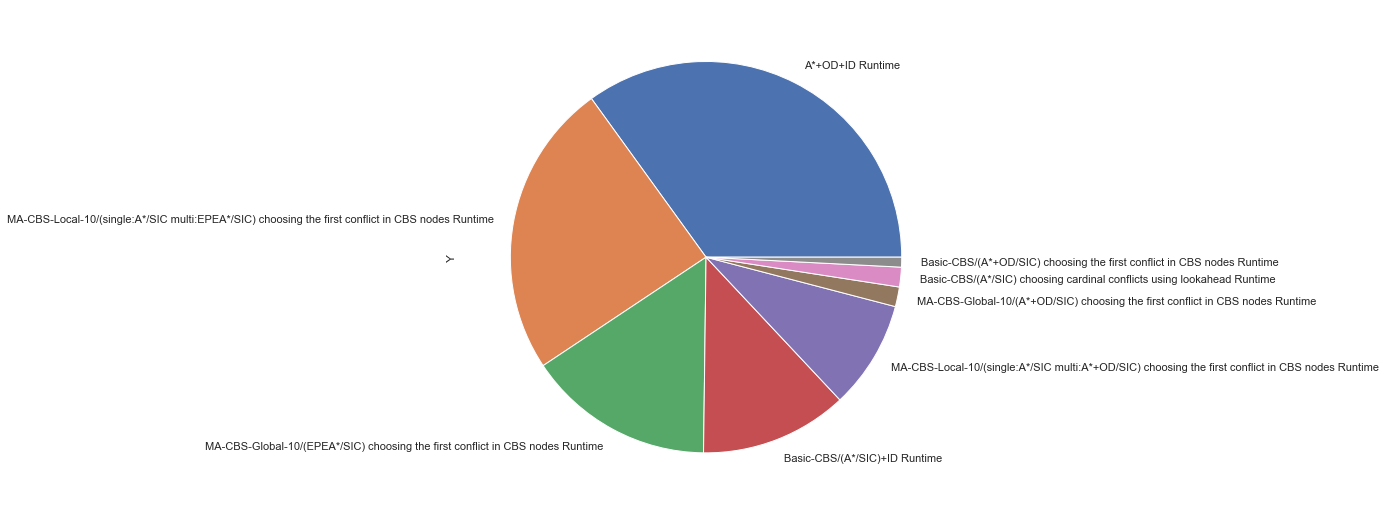

In [342]:
pd.Series(y_test).value_counts().plot(kind='pie')